<a href="https://colab.research.google.com/github/hayleypc/HawaiiClimate/blob/main/Maui_carbon_landuse_climate_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install fiona

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.2/17.2 MB 97.6 MB/s eta 0:00:00


In [2]:
import geopandas as gpd
import pandas as pd
import numpy as np
import fiona
from datetime import datetime
import matplotlib.pyplot as plt

In [15]:
df = gpd.read_file('/content/maui_carbon_analysis_with_polyids.gpkg', engine='fiona')

Available layers: ['maui_carbon_analysis']


In [5]:
# Get all the monthly carbon columns
date_cols = [col for col in df.columns if col.startswith('d_')]
print(f"Found {len(date_cols)} monthly predictions")
print(f"Date range: {date_cols[0]} to {date_cols[-1]}")

# Extract year from column names to identify first and last year
def get_year(col):
    date_str = col.split('_')[1]
    return int(date_str[:4])

# Get unique years
years = sorted(set([get_year(col) for col in date_cols]))
first_year = 2017
last_year = 2024

print(f"First year: {first_year}")
print(f"Last year: {last_year}")

# Get columns for first and last year
first_year_cols = [col for col in date_cols if get_year(col) == first_year]
last_year_cols = [col for col in date_cols if get_year(col) == last_year]

print(f"First year columns ({first_year}): {len(first_year_cols)} months")
print(f"Last year columns ({last_year}): {len(last_year_cols)} months")

Found 98 monthly predictions
Date range: d_20161217 to d_20241205
First year: 2017
Last year: 2024
First year columns (2017): 12 months
Last year columns (2024): 12 months


In [16]:
## across subregion, not grouped by polygon

# Calculate mean carbon across all months
df['carbon_mean'] = df[date_cols].mean(axis=1)
df['carbon_median'] = df[date_cols].median(axis=1)
df['carbon_std'] = df[date_cols].std(axis=1)
df['carbon_min'] = df[date_cols].min(axis=1)
df['carbon_max'] = df[date_cols].max(axis=1)

# Add first and last year averages
df['carbon_first_year'] = df[first_year_cols].mean(axis=1)
df['carbon_last_year'] = df[last_year_cols].mean(axis=1)

# Calculate change over time
df['carbon_change'] = df['carbon_last_year'] - df['carbon_first_year']
df['carbon_pct_change'] = ((df['carbon_last_year'] - df['carbon_first_year']) /
                                       df['carbon_first_year']) * 100

# Use the temporal mean for summaries
carbon_col = 'carbon_mean'

print(f"\nCarbon statistics:")
print(f"  Overall mean: {df['carbon_mean'].mean():.2f}%")
print(f"  First year ({first_year}) mean: {df['carbon_first_year'].mean():.2f}%")
print(f"  Last year ({last_year}) mean: {df['carbon_last_year'].mean():.2f}%")
print(f"  Average change: {df['carbon_change'].mean():.2f}% ({df['carbon_pct_change'].mean():.2f}% change)")


Carbon statistics:
  Overall mean: 3.71%
  First year (2017) mean: 4.04%
  Last year (2024) mean: 3.19%
  Average change: -0.76% (-22.08% change)


In [40]:
# Group by polygon and calculate statistics
polygon_summary = df.groupby('polygonid').agg({
    # Take first value for categorical/constant columns
    'landuse_historic': 'first',
    'landuse_current': 'first',
    'land_use_transition': 'first',
    'geometry': 'first',

    # Calculate mean across all points in each polygon for carbon metrics
    'carbon_mean': 'mean',
    'carbon_median': 'mean',
    'carbon_std': 'mean',
    'carbon_min': 'mean',
    'carbon_max': 'mean',
    'carbon_first_year': 'mean',
    'carbon_last_year': 'mean',
    'carbon_change': 'mean',
    'carbon_pct_change': 'mean'
}).reset_index()

# Convert back to GeoDataFrame
polygon_summary = gpd.GeoDataFrame(polygon_summary, geometry='geometry')

# Filter to keep only transitions with more than 1 polygon
transition_counts = polygon_summary['land_use_transition'].value_counts()
transitions_to_keep = transition_counts[transition_counts > 1].index
polygon_summary_filtered = polygon_summary[polygon_summary['land_use_transition'].isin(transitions_to_keep)]

# Print statistics for filtered dataset
print(f"\n{'='*80}")
print("FILTERED POLYGON-LEVEL CARBON STATISTICS")
print(f"{'='*80}")
print(f"\nFiltering summary:")
print(f"  Original polygons: {len(polygon_summary)}")
print(f"  Filtered polygons: {len(polygon_summary_filtered)}")
print(f"  Original unique transitions: {len(transition_counts)}")
print(f"  Filtered unique transitions: {len(transitions_to_keep)}")
print(f"  Removed transitions (single polygon): {len(transition_counts[transition_counts == 1])}")

print(f"\nOverall statistics:")
print(f"  Mean SOC: {polygon_summary_filtered['carbon_mean'].mean():.2f}%")
print(f"  First year ({first_year}) mean: {polygon_summary_filtered['carbon_first_year'].mean():.2f}%")
print(f"  Last year ({last_year}) mean: {polygon_summary_filtered['carbon_last_year'].mean():.2f}%")
print(f"  Average change: {polygon_summary_filtered['carbon_change'].mean():.2f}% ({polygon_summary_filtered['carbon_pct_change'].mean():.2f}% change)")

# Display summary by land use transition
print(f"\nBy land use transition:")
for transition in sorted(polygon_summary_filtered['land_use_transition'].unique()):
    trans_data = polygon_summary_filtered[polygon_summary_filtered['land_use_transition'] == transition]
    print(f"\n  {transition}:")
    print(f"    Polygons: {len(trans_data)}")
    print(f"    Mean SOC: {trans_data['carbon_mean'].mean():.2f}%")
    print(f"    Mean change: {trans_data['carbon_change'].mean():.2f}% ({trans_data['carbon_pct_change'].mean():.2f}%)")


FILTERED POLYGON-LEVEL CARBON STATISTICS

Filtering summary:
  Original polygons: 297
  Filtered polygons: 294
  Original unique transitions: 12
  Filtered unique transitions: 9
  Removed transitions (single polygon): 3

Overall statistics:
  Mean SOC: 4.01%
  First year (2017) mean: 4.14%
  Last year (2024) mean: 3.58%
  Average change: -0.55% (-15.30% change)

By land use transition:

  diversified → diversified:
    Polygons: 34
    Mean SOC: 4.59%
    Mean change: -0.21% (-3.96%)

  diversified → pineapple:
    Polygons: 44
    Mean SOC: 4.79%
    Mean change: -0.14% (-2.48%)

  diversified → rangeland:
    Polygons: 4
    Mean SOC: 4.88%
    Mean change: -0.53% (-10.26%)

  pineapple → abandoned:
    Polygons: 33
    Mean SOC: 4.61%
    Mean change: -0.42% (-8.32%)

  pineapple → rangeland:
    Polygons: 20
    Mean SOC: 4.22%
    Mean change: -0.51% (-11.08%)

  rangeland → rangeland:
    Polygons: 36
    Mean SOC: 5.60%
    Mean change: -0.46% (-8.73%)

  sugarcane → abandoned:

Found 9 unique land use transitions


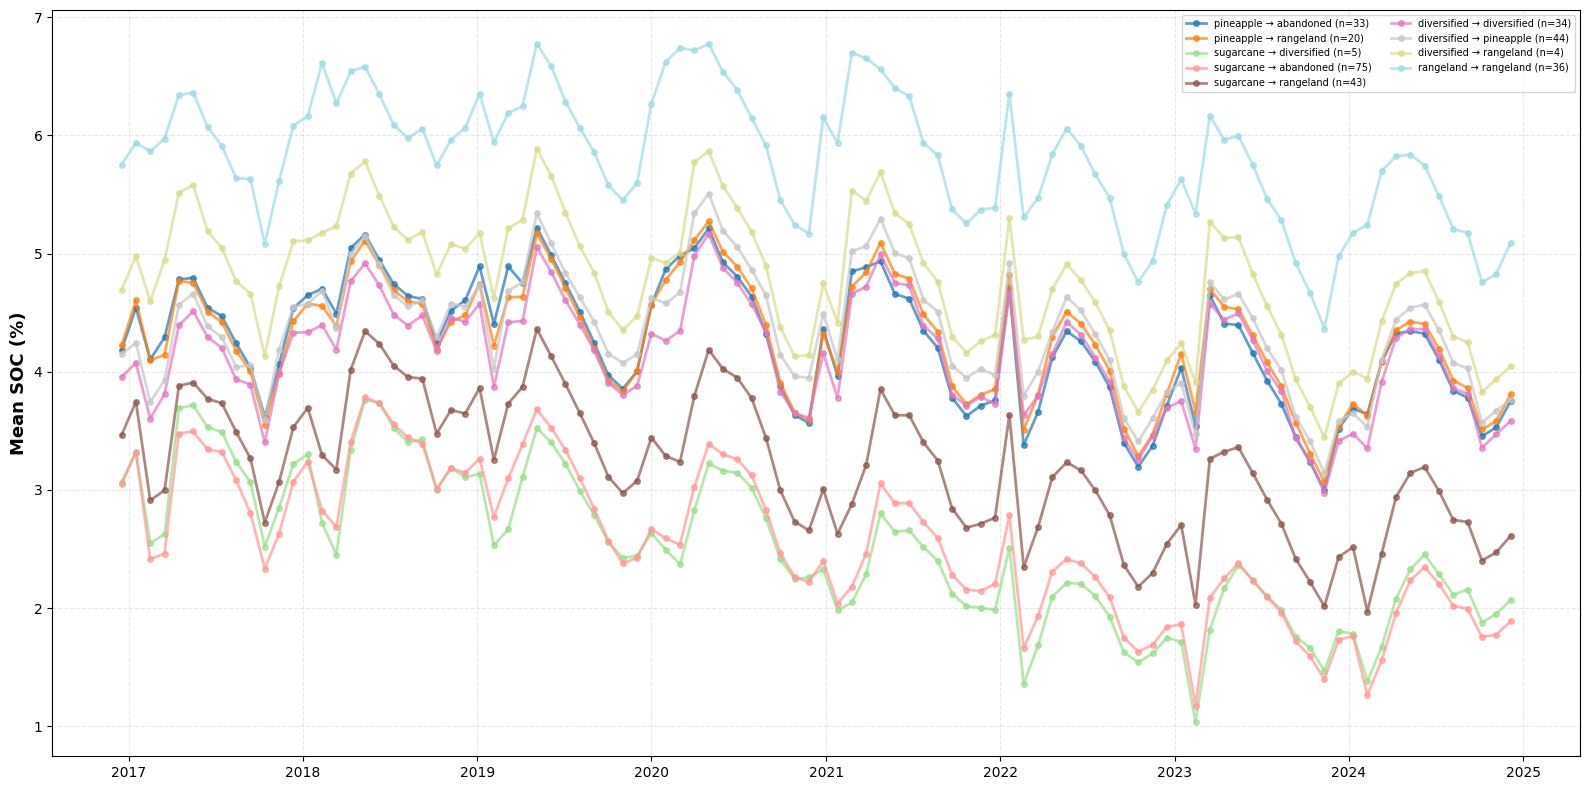

In [42]:
# Get all date columns from polygon_summary dataframe
date_cols = [col for col in df.columns if col.startswith('d_')]

# Extract dates from column names
dates = [datetime.strptime(col.replace('d_', ''), '%Y%m%d') for col in date_cols]

# Get all unique transitions from polygon_summary_filtered
transitions = polygon_summary_filtered['land_use_transition'].unique()
print(f"Found {len(transitions)} unique land use transitions")

# Create figure
fig, ax = plt.subplots(figsize=(16, 8))

# Define colors for each transition
colors = plt.cm.tab20(np.linspace(0, 1, len(transitions)))

# Plot for each land use transition
for idx, transition in enumerate(transitions):
    # Get polygon IDs for this transition
    polygon_ids = polygon_summary_filtered[polygon_summary_filtered['land_use_transition'] == transition]['polygonid']

    # Filter original df data for these polygons
    transition_data = df[df['polygonid'].isin(polygon_ids)]

    # Calculate mean for each date across all points in these polygons
    yearly_means = []
    for date_col in date_cols:
        yearly_means.append(transition_data[date_col].mean())

    # Plot
    ax.plot(dates, yearly_means,
            marker='o', linewidth=2, markersize=4,
            label=f'{transition} (n={len(polygon_ids)})',
            color=colors[idx], alpha=0.7)

ax.set_ylabel('Mean SOC (%)', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(loc='best', fontsize=7, ncol=2)
plt.tight_layout()
plt.show()

In [45]:
# Create summary dataframe from polygon_summary_filtered with increase/decrease counts
summary_data = []

for transition in polygon_summary_filtered['land_use_transition'].unique():
    transition_data = polygon_summary_filtered[polygon_summary_filtered['land_use_transition'] == transition]

    # Get statistics directly from polygon-level data
    mean_soc = transition_data['carbon_mean'].mean()
    std_soc = transition_data['carbon_mean'].std()
    first_year_mean = transition_data['carbon_first_year'].mean()
    last_year_mean = transition_data['carbon_last_year'].mean()
    change = transition_data['carbon_change'].mean()
    pct_change = transition_data['carbon_pct_change'].mean()

    # Count increases and decreases
    n_increased = (transition_data['carbon_change'] > 0).sum()
    n_decreased = (transition_data['carbon_change'] < 0).sum()

    summary_data.append({
        'Transition': transition,
        'N Polygons': len(transition_data),
        'N Increased': n_increased,
        'N Decreased': n_decreased,
        'Mean SOC (%)': round(mean_soc, 2),
        'Std Dev (%)': round(std_soc, 2),
        f'SOC {first_year} (%)': round(first_year_mean, 2),
        f'SOC {last_year} (%)': round(last_year_mean, 2),
        'Absolute Change (%)': round(change, 2),
        'Change (% relative)': round(pct_change, 1)
    })

# Create DataFrame
summary_table = pd.DataFrame(summary_data)
summary_table = summary_table.sort_values(['N Polygons'], ascending=[False])

print("\n" + "="*120)
print("LAND USE TRANSITION SUMMARY (POLYGON LEVEL)")
print("="*120)

# Display with nice formatting
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_rows', None)

display(summary_table)


LAND USE TRANSITION SUMMARY (POLYGON LEVEL)


,Transition,N Polygons,N Increased,N Decreased,Mean SOC (%),Std Dev (%),SOC 2017 (%),SOC 2024 (%),Absolute Change (%),Change (% relative)
3,sugarcane → abandoned,75,1,74,2.64,0.57,3.04,2.06,-0.98,-32.5
6,diversified → pineapple,44,12,32,4.79,0.98,4.63,4.49,-0.14,-2.5
4,sugarcane → rangeland,43,4,39,3.31,0.57,3.53,2.88,-0.64,-18.6
8,rangeland → rangeland,36,3,33,5.60,1.69,5.63,5.16,-0.46,-8.7
5,diversified → diversified,34,10,24,4.59,1.05,4.49,4.28,-0.21,-4.0
0,pineapple → abandoned,33,0,33,4.61,0.34,4.69,4.27,-0.42,-8.3
1,pineapple → rangeland,20,0,20,4.22,0.73,4.37,3.86,-0.51,-11.1
2,sugarcane → diversified,5,0,5,2.48,0.29,3.03,2.00,-1.03,-33.0
7,diversified → rangeland,4,0,4,4.88,0.55,4.98,4.45,-0.53,-10.3


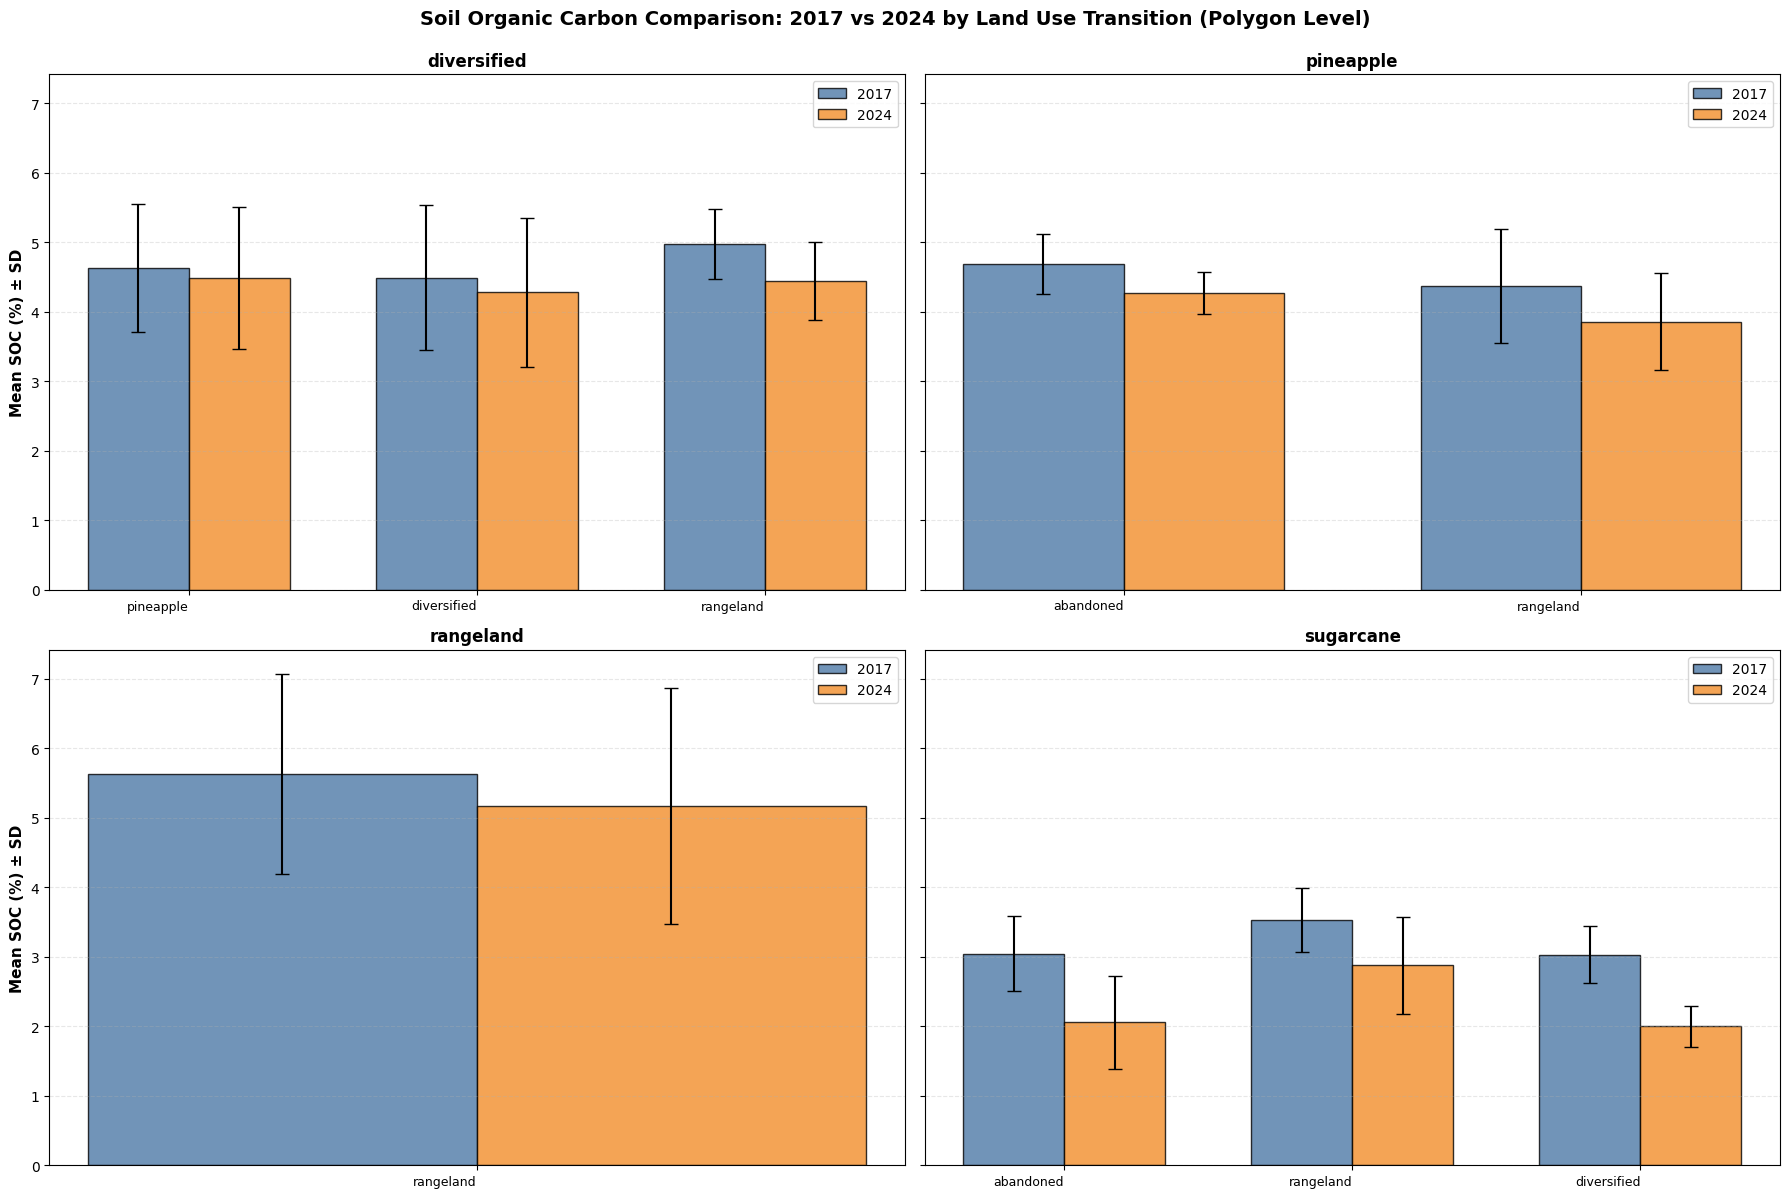

In [47]:
# Create summary data for 2017 and 2024 from polygon_summary_filtered
plot_data = []
for transition in polygon_summary_filtered['land_use_transition'].unique():
    transition_data = polygon_summary_filtered[polygon_summary_filtered['land_use_transition'] == transition]
    starting_land_use = transition.split(' → ')[0]

    # Get means and standard deviations from polygon-level data
    soc_2017_mean = transition_data['carbon_first_year'].mean()
    soc_2017_sd = transition_data['carbon_first_year'].std()
    soc_2024_mean = transition_data['carbon_last_year'].mean()
    soc_2024_sd = transition_data['carbon_last_year'].std()

    plot_data.append({
        'starting_land_use': starting_land_use,
        'transition': transition,
        'soc_2017_mean': soc_2017_mean,
        'soc_2017_sd': soc_2017_sd,
        'soc_2024_mean': soc_2024_mean,
        'soc_2024_sd': soc_2024_sd,
        'n_polygons': len(transition_data)
    })

plot_df = pd.DataFrame(plot_data)
plot_df = plot_df.sort_values(['starting_land_use', 'n_polygons'], ascending=[True, False])

# Get unique starting land uses
starting_land_uses = plot_df['starting_land_use'].unique()

# Create subplots - adjust dimensions based on number of starting land uses
n_plots = len(starting_land_uses)
n_cols = 2
n_rows = (n_plots + n_cols - 1) // n_cols  # Ceiling division
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6*n_rows), sharey=True)
axes = axes.flatten()  # Flatten to make indexing easier

for idx, starting_lu in enumerate(starting_land_uses):
    ax = axes[idx]

    # Filter data for this starting land use
    lu_data = plot_df[plot_df['starting_land_use'] == starting_lu]

    # Number of transitions in this group
    n_transitions = len(lu_data)
    x_pos = np.arange(n_transitions)
    width = 0.35

    # Create bars for 2017 and 2024
    bars1 = ax.bar(x_pos - width/2, lu_data['soc_2017_mean'], width,
                   yerr=lu_data['soc_2017_sd'],
                   label='2017', capsize=5, alpha=0.8,
                   color='#4e79a7', edgecolor='black', linewidth=1)

    bars2 = ax.bar(x_pos + width/2, lu_data['soc_2024_mean'], width,
                   yerr=lu_data['soc_2024_sd'],
                   label='2024', capsize=5, alpha=0.8,
                   color='#f28e2b', edgecolor='black', linewidth=1)

    # Customize subplot
    if idx % n_cols == 0:  # Left column
        ax.set_ylabel('Mean SOC (%) ± SD', fontsize=11, fontweight='bold')
    ax.set_title(f'{starting_lu}', fontsize=12, fontweight='bold')
    ax.set_xticks(x_pos)

    # Create labels showing ending state
    labels = [t.split(' → ')[1] for t in lu_data['transition']]
    ax.set_xticklabels(labels, ha='right', fontsize=9)
    ax.grid(True, alpha=0.3, linestyle='--', axis='y')
    ax.legend(loc='upper right', fontsize=10)

# Hide extra subplots if needed
for idx in range(n_plots, len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('Soil Organic Carbon Comparison: 2017 vs 2024 by Land Use Transition (Polygon Level)',
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

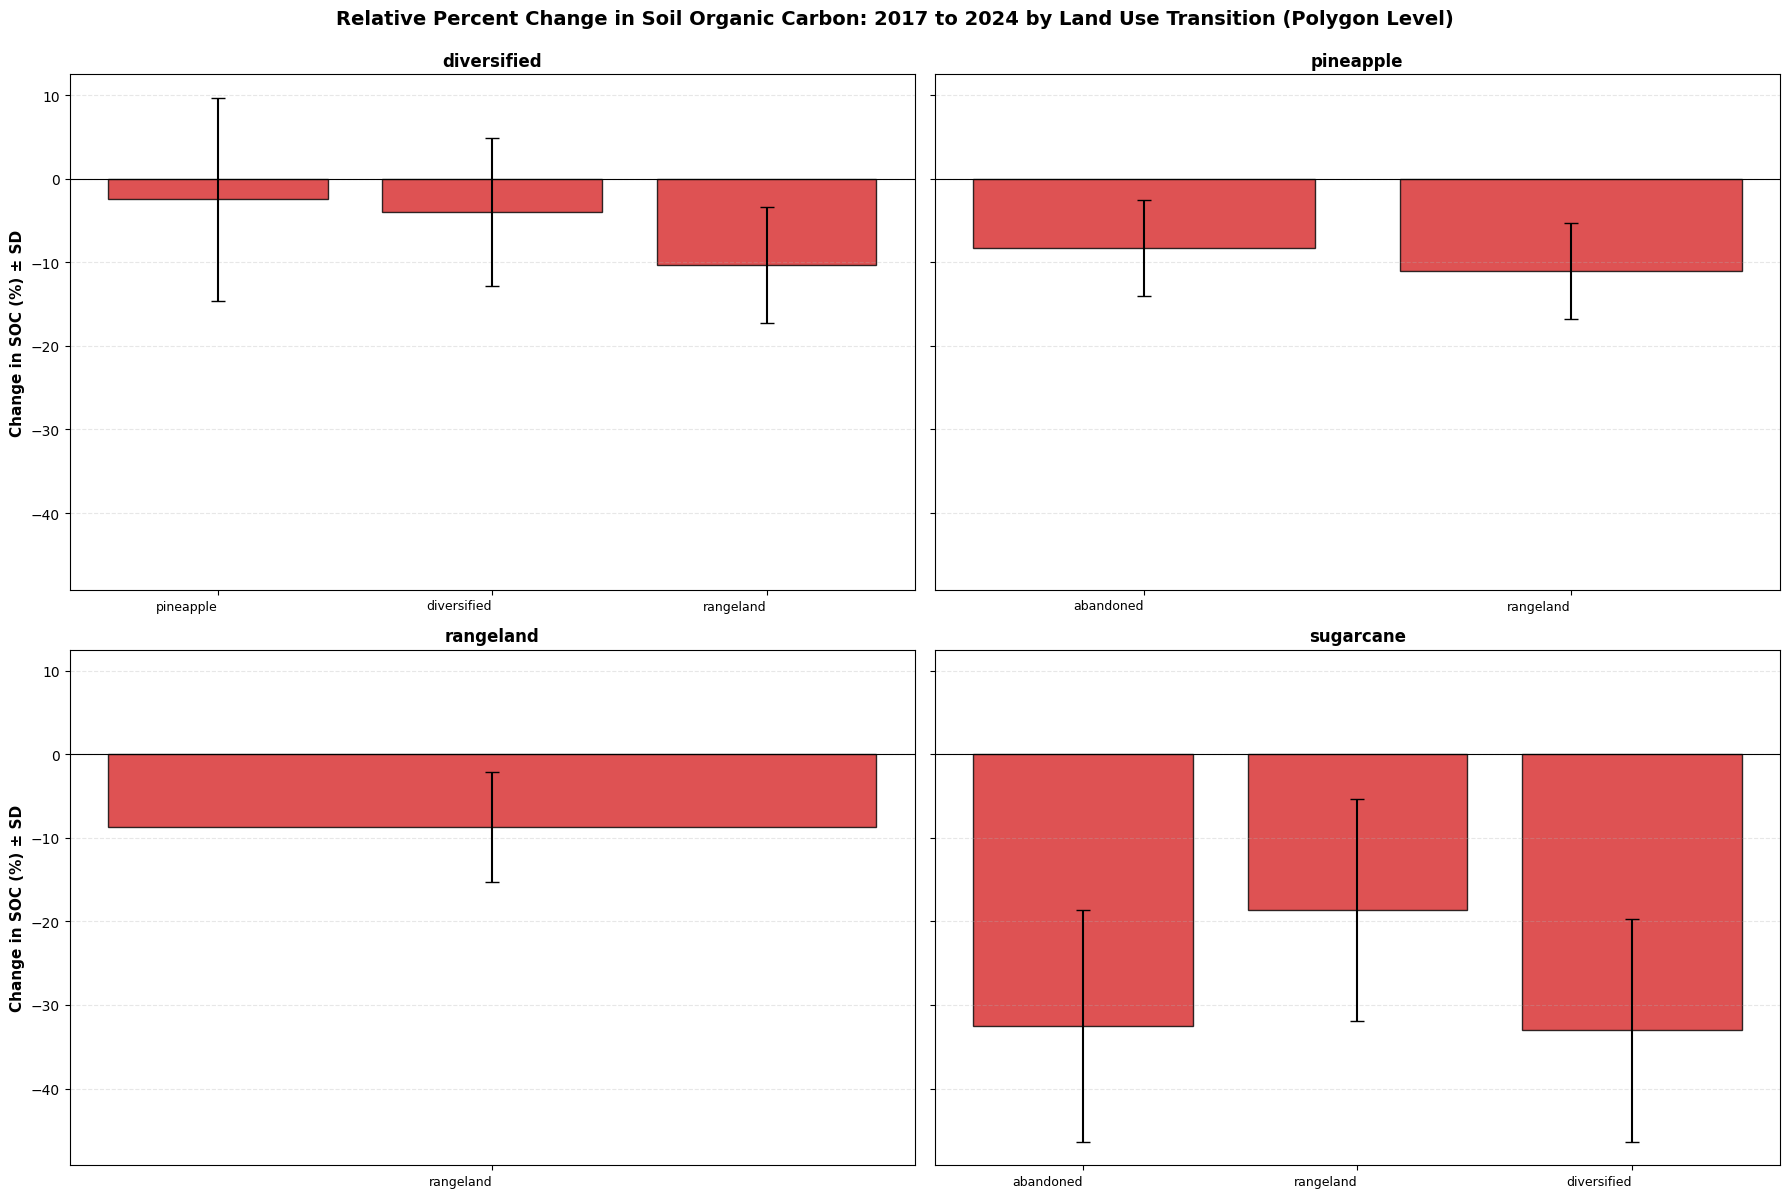

In [49]:
# Create summary data for percent change from 2017 to 2024 from polygon_summary_filtered
plot_data = []
for transition in polygon_summary_filtered['land_use_transition'].unique():
    transition_data = polygon_summary_filtered[polygon_summary_filtered['land_use_transition'] == transition]
    starting_land_use = transition.split(' → ')[0]

    # Get percent change statistics from polygon-level data
    pct_change_mean = transition_data['carbon_pct_change'].mean()
    pct_change_sd = transition_data['carbon_pct_change'].std()

    plot_data.append({
        'starting_land_use': starting_land_use,
        'transition': transition,
        'pct_change': pct_change_mean,
        'pct_change_sd': pct_change_sd,
        'n_polygons': len(transition_data)
    })

plot_df = pd.DataFrame(plot_data)
plot_df = plot_df.sort_values(['starting_land_use', 'n_polygons'], ascending=[True, False])

# Get unique starting land uses
starting_land_uses = plot_df['starting_land_use'].unique()

# Create subplots - adjust dimensions based on number of starting land uses
n_plots = len(starting_land_uses)
n_cols = 2
n_rows = (n_plots + n_cols - 1) // n_cols  # Ceiling division
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6*n_rows), sharey=True)
axes = axes.flatten()  # Flatten to make indexing easier

for idx, starting_lu in enumerate(starting_land_uses):
    ax = axes[idx]

    # Filter data for this starting land use
    lu_data = plot_df[plot_df['starting_land_use'] == starting_lu]

    # Number of transitions in this group
    n_transitions = len(lu_data)
    x_pos = np.arange(n_transitions)

    # Color bars based on positive (green) or negative (red) change
    colors = ['#2ca02c' if pct >= 0 else '#d62728' for pct in lu_data['pct_change']]

    # Create bars for percent change with error bars
    bars = ax.bar(x_pos, lu_data['pct_change'],
                  yerr=lu_data['pct_change_sd'],
                  capsize=5,
                  alpha=0.8,
                  color=colors,
                  edgecolor='black', linewidth=1)

    # Add horizontal line at 0
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)

    # Customize subplot
    if idx % n_cols == 0:  # Left column
        ax.set_ylabel('Change in SOC (%) ± SD', fontsize=11, fontweight='bold')
    ax.set_title(f'{starting_lu}', fontsize=12, fontweight='bold')
    ax.set_xticks(x_pos)

    # Create labels showing ending state
    labels = [t.split(' → ')[1] for t in lu_data['transition']]
    ax.set_xticklabels(labels, ha='right', fontsize=9)
    ax.grid(True, alpha=0.3, linestyle='--', axis='y')

# Hide extra subplots if needed
for idx in range(n_plots, len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('Relative Percent Change in Soil Organic Carbon: 2017 to 2024 by Land Use Transition (Polygon Level)',
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

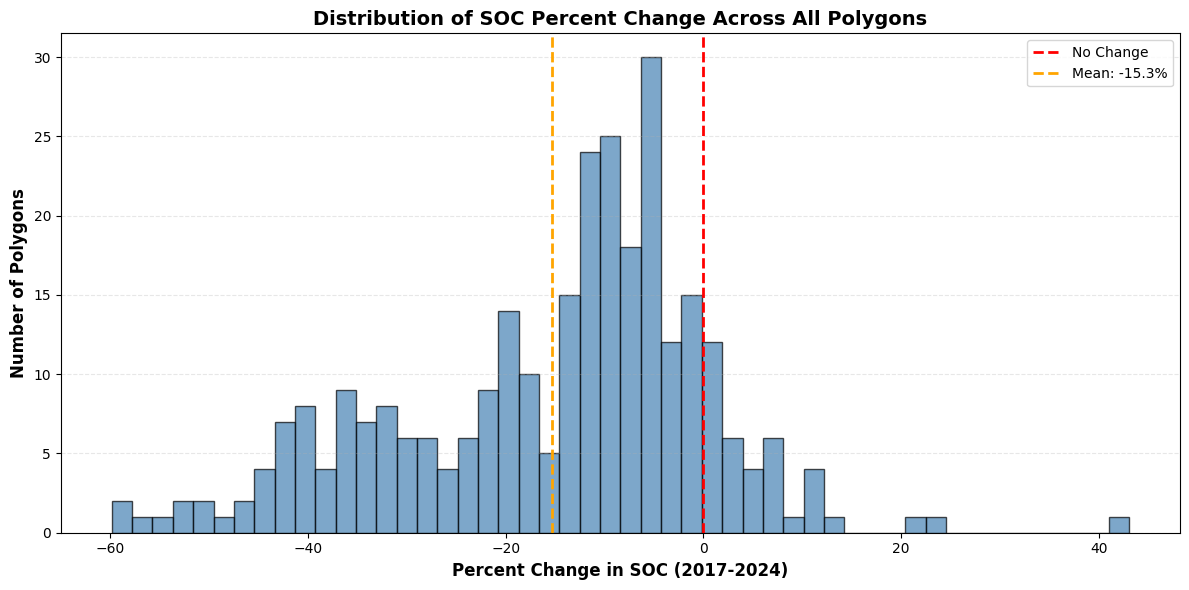

Total unique polygons: 294


/usr/local/lib/python3.12/dist-packages/geopandas/geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


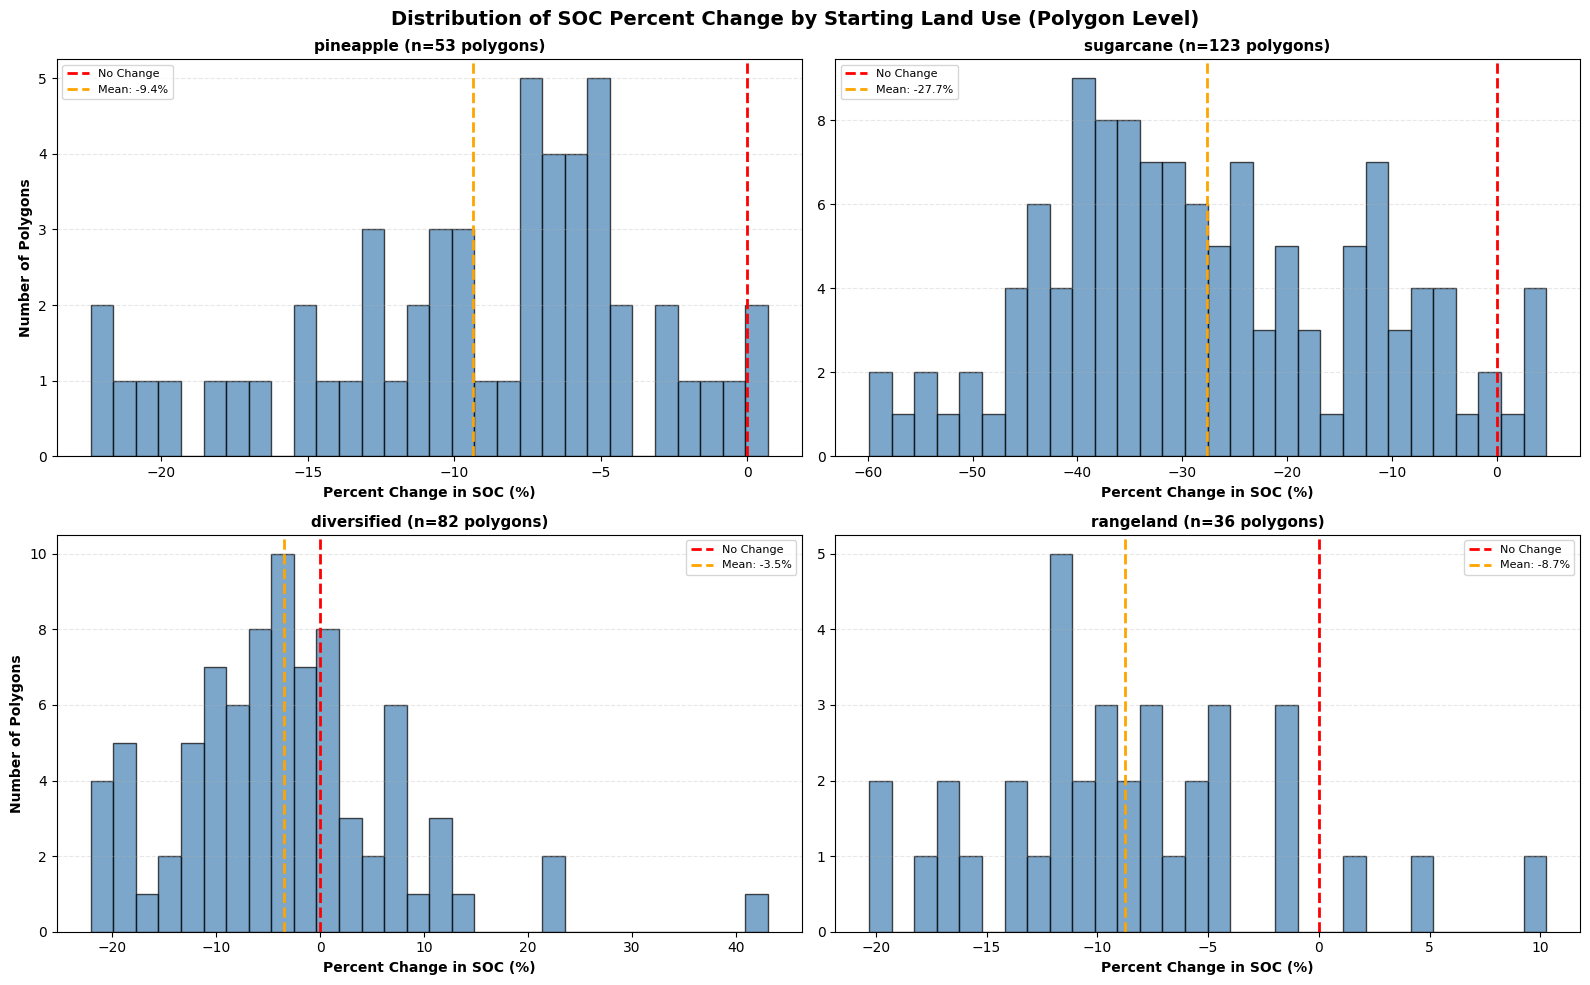

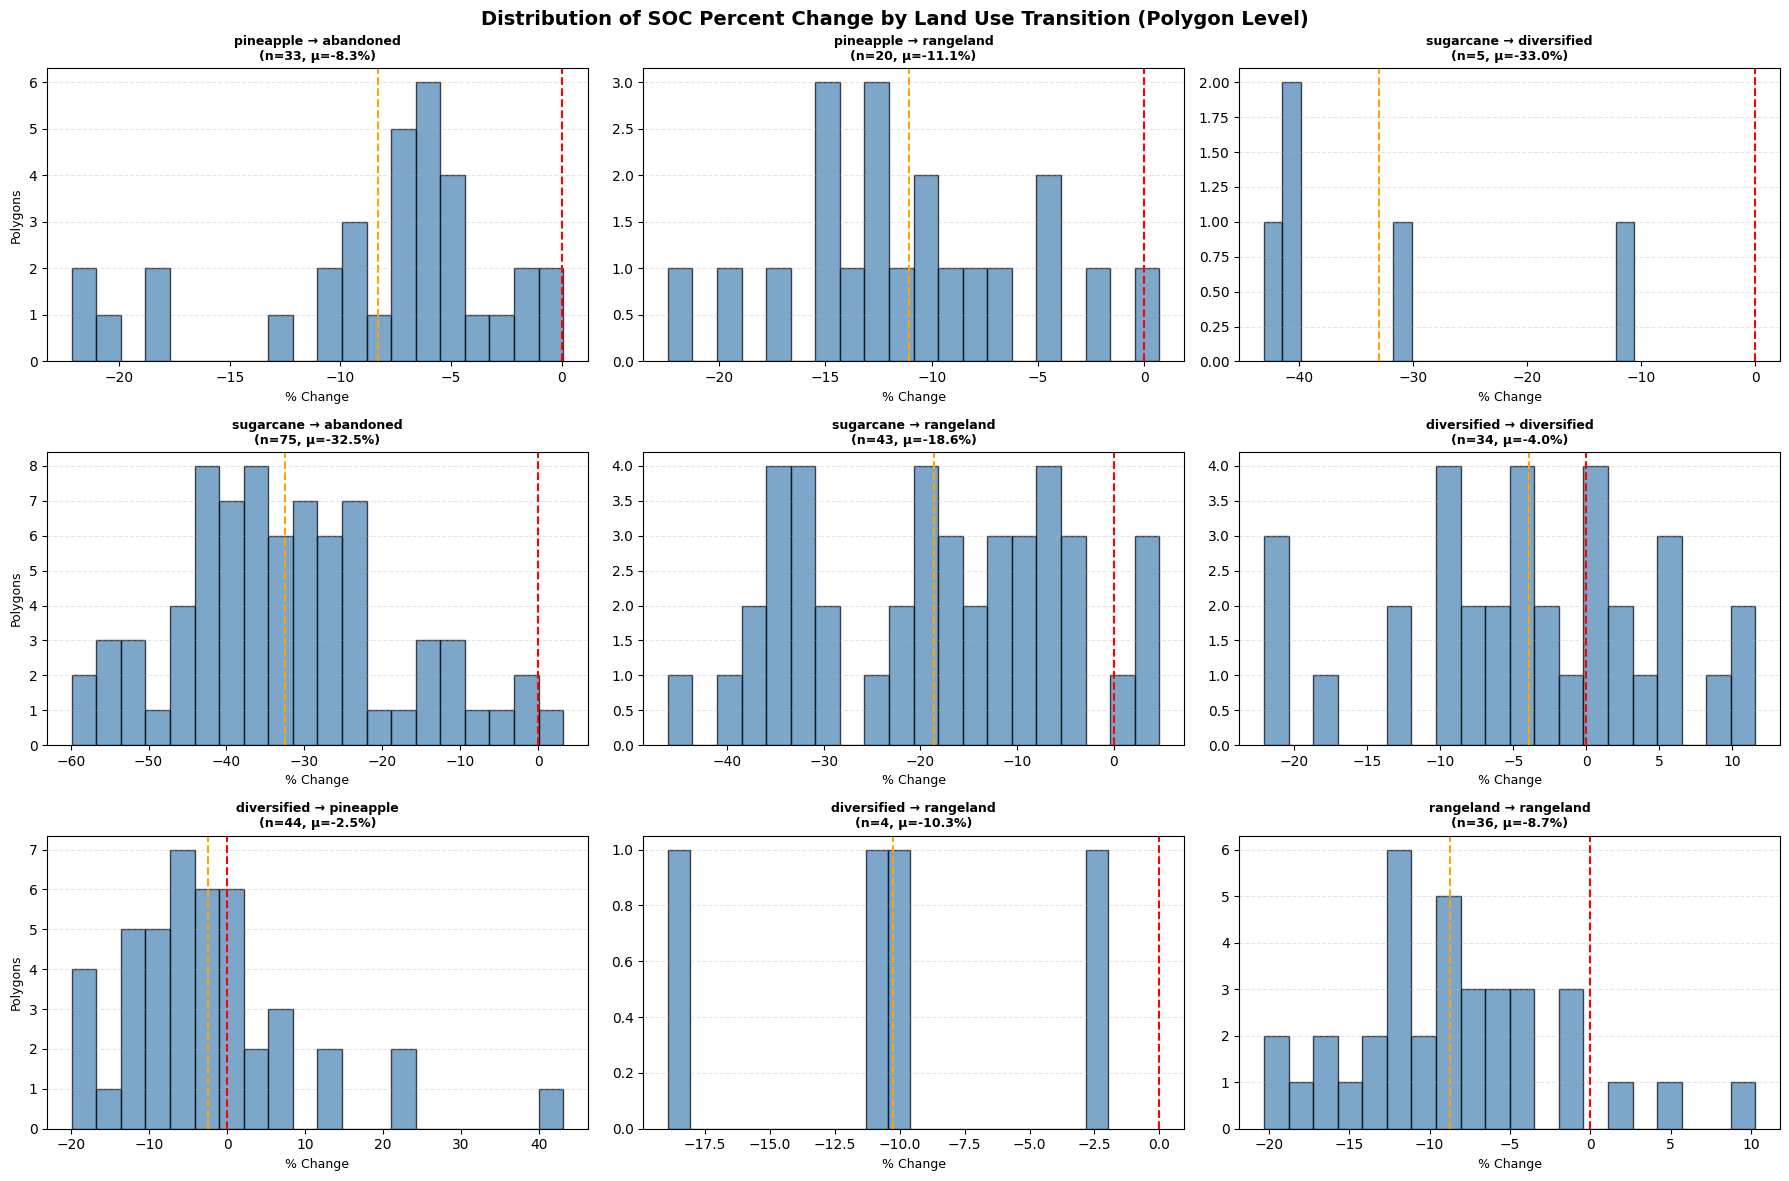

In [50]:
# 1. Overall histogram by polygon
fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(polygon_summary_filtered['carbon_pct_change'].dropna(), bins=50, edgecolor='black', alpha=0.7, color='steelblue')
ax.axvline(x=0, color='red', linestyle='--', linewidth=2, label='No Change')
ax.axvline(x=polygon_summary_filtered['carbon_pct_change'].mean(), color='orange', linestyle='--', linewidth=2,
           label=f'Mean: {polygon_summary_filtered["carbon_pct_change"].mean():.1f}%')
ax.set_xlabel('Percent Change in SOC (2017-2024)', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Polygons', fontsize=12, fontweight='bold')
ax.set_title('Distribution of SOC Percent Change Across All Polygons', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3, linestyle='--', axis='y')
plt.tight_layout()
plt.show()

print(f"Total unique polygons: {len(polygon_summary_filtered)}")

# 2. Histograms by starting land use
polygon_summary_filtered['starting_land_use'] = polygon_summary_filtered['land_use_transition'].apply(lambda x: x.split(' → ')[0])
starting_land_uses = polygon_summary_filtered['starting_land_use'].unique()

n_plots = len(starting_land_uses)
n_cols = 2
n_rows = (n_plots + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 5*n_rows))
axes = axes.flatten()

for idx, starting_lu in enumerate(starting_land_uses):
    ax = axes[idx]

    # Get data for this starting land use
    lu_data = polygon_summary_filtered[polygon_summary_filtered['starting_land_use'] == starting_lu]

    # Create histogram
    ax.hist(lu_data['carbon_pct_change'].dropna(), bins=30, edgecolor='black', alpha=0.7, color='steelblue')
    ax.axvline(x=0, color='red', linestyle='--', linewidth=2, label='No Change')
    ax.axvline(x=lu_data['carbon_pct_change'].mean(), color='orange', linestyle='--', linewidth=2,
               label=f'Mean: {lu_data["carbon_pct_change"].mean():.1f}%')

    ax.set_xlabel('Percent Change in SOC (%)', fontsize=10, fontweight='bold')
    if idx % n_cols == 0:
        ax.set_ylabel('Number of Polygons', fontsize=10, fontweight='bold')
    ax.set_title(f'{starting_lu} (n={len(lu_data)} polygons)', fontsize=11, fontweight='bold')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3, linestyle='--', axis='y')

# Hide extra subplots if needed
for idx in range(n_plots, len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('Distribution of SOC Percent Change by Starting Land Use (Polygon Level)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# 3. Histograms by specific transition (all transitions)
transitions = polygon_summary_filtered['land_use_transition'].unique()
n_plots = len(transitions)
n_cols = 3
n_rows = (n_plots + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4*n_rows))
axes = axes.flatten()

for idx, transition in enumerate(transitions):
    ax = axes[idx]

    # Get data for this transition
    trans_data = polygon_summary_filtered[polygon_summary_filtered['land_use_transition'] == transition]

    # Create histogram
    ax.hist(trans_data['carbon_pct_change'].dropna(), bins=20, edgecolor='black', alpha=0.7, color='steelblue')
    ax.axvline(x=0, color='red', linestyle='--', linewidth=1.5)
    ax.axvline(x=trans_data['carbon_pct_change'].mean(), color='orange', linestyle='--', linewidth=1.5)

    ax.set_xlabel('% Change', fontsize=9)
    if idx % n_cols == 0:
        ax.set_ylabel('Polygons', fontsize=9)
    ax.set_title(f'{transition}\n(n={len(trans_data)}, μ={trans_data["carbon_pct_change"].mean():.1f}%)',
                 fontsize=9, fontweight='bold')
    ax.grid(True, alpha=0.3, linestyle='--', axis='y')

# Hide extra subplots if needed
for idx in range(n_plots, len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('Distribution of SOC Percent Change by Land Use Transition (Polygon Level)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()